In [2]:
from typing import Union

import tensorflow as tf
import tensorflow.keras as K
import numpy as np

import matplotlib.pyplot as plt

from gpt.modeling import (GPT1Config, GPT)
from gpt.trainer import (TrainerConfig, Trainer)

In [3]:
(train_images, train_labels), (test_images, test_labels) = K.datasets.cifar10.load_data()

In [4]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
def show_samples(images, labels, num=25):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(class_names[labels[i][0]])
    plt.show()

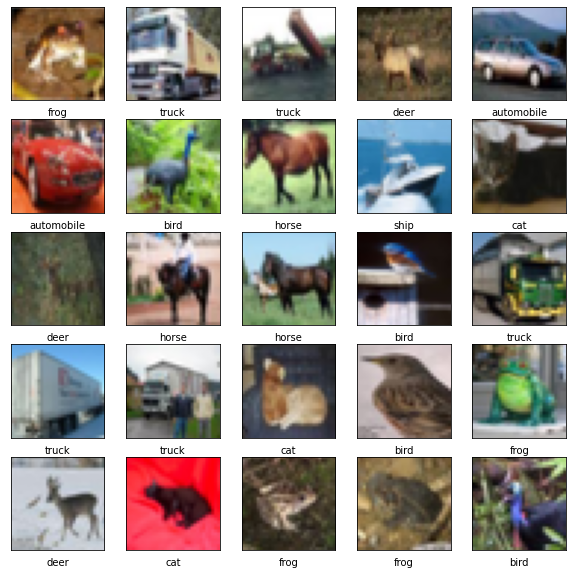

In [6]:
show_samples(train_images, train_labels)

In [6]:
train_images[0].shape

(32, 32, 3)

In [7]:
len(train_images)

50000

In [8]:
@tf.function(jit_compile=True)
def pluck_rgb(x):
    x = tf.reshape(x, (-1, 3))
    rand_pixel_ids = tf.random.shuffle(range(32*32))[:5]
    output = tf.gather(x, rand_pixel_ids)
    return output

In [9]:
px = tf.concat([pluck_rgb(x) for x in train_images], axis=0)

2022-08-03 13:19:30.566183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 13:19:31.184970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38304 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2022-08-03 13:19:31.983345: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x558f1c2b33d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-03 13:19:31.983389: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2022-08-03 13:19:31.988115: I t

In [10]:
px.shape

TensorShape([250000, 3])

In [11]:
# @tf.function(jit_compile=True)
def compute_distance_approx(x, y):
    similarity = tf.matmul(x, y, transpose_b=True)
    distances = (
       tf.reduce_sum(x ** 2, axis=1, keepdims=True)
       + tf.reduce_sum(y ** 2, axis=1)
        - 2 * similarity
    )
    return distances

In [12]:
# @tf.function(jit_compile=True)
def compute_distance_full(x, y):
    a = tf.reduce_sum((x[:, None, :] - y[None, :, :])**2, axis=-1)
    return a

In [13]:
@tf.function(jit_compile=True)
def compute_distance_full_tf(x, y):
    a = tf.reduce_sum(tf.square(tf.subtract(x[:, None, :], y[None, :, :])), axis=2)
    return a

In [14]:
# run kmeans to get our codebook
def kmeans(x, ncluster, niter=10):
    N, D = x.shape
    c = tf.gather(x, indices=tf.random.shuffle(range(N))[:ncluster]) # init clusters at random
    for i in range(niter):
        a = compute_distance_approx(x, c)
        a = tf.argmin(a, axis=1) # N
        # move each codebook element to be the mean of the pixels that assigned to it
        c = tf.stack([tf.reduce_mean(x[a==k], axis=0) for k in range(ncluster)]) # C x D
        # re-assign any poorly positioned codebook elements
        nanix = tf.math.reduce_any(tf.math.is_nan(c), axis=1) # C
        ndead = tf.reduce_sum(tf.cast(nanix, dtype=tf.int32)) # scalar
        tf.print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, int(ndead)))
        if ndead > 0:
            rnd_init = tf.gather(x, tf.random.shuffle(range(N))[:ndead])
            c = tf.tensor_scatter_nd_update(
                c, tf.where(nanix), rnd_init
            )
    return c

In [15]:
ncluster = 512
C = kmeans(px, ncluster, niter=8)

done step 1/8, re-initialized 4 dead clusters
done step 2/8, re-initialized 0 dead clusters
done step 3/8, re-initialized 0 dead clusters
done step 4/8, re-initialized 0 dead clusters
done step 5/8, re-initialized 0 dead clusters
done step 6/8, re-initialized 0 dead clusters
done step 7/8, re-initialized 0 dead clusters
done step 8/8, re-initialized 0 dead clusters


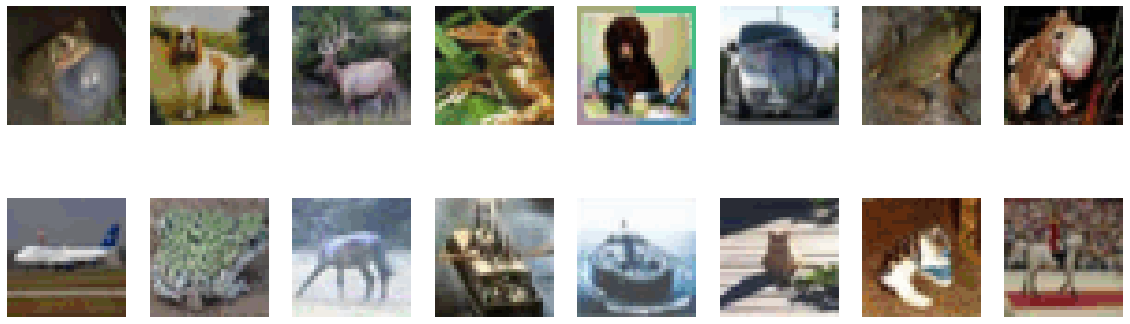

In [16]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    # encode and decode random data
    x = train_images[np.random.randint(0, len(train_images))] # 28 x 28 x 3
    xpt = tf.reshape(x, (-1, 3)) # 1024 x 3
    a = compute_distance_approx(xpt, C) # 1024 x C
    ix = tf.argmin(a, axis=1) # 1024
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    decode_img = (
        tf.cast(
        tf.reshape(
            tf.gather(C, indices=ix), shape=(32, 32, 3)
        ), dtype=tf.float32)
    )
    plt.imshow(decode_img)
    plt.axis('off')

In [17]:
class ImageDataset(tf.data.Dataset):
    @classmethod
    def _gen_examples_from(
        cls, data: tf.Tensor, clusters: tf.Tensor, perm: Union[tf.Tensor, list]
    ):
        def _gen():
            nonlocal data
            _, H, W, C = data.shape
            data_flatten = tf.reshape(data, (-1, H*W, C))
            for idx in range(len(data_flatten)):
                image = tf.gather(data_flatten[idx], indices=perm)
                a = tf.argmin(
                    compute_distance_approx(image, clusters), axis=1
                )
                yield a[:-1], a[1:] # always just predict the next one in the sequence
        return _gen

    def __new__(
        cls, images: tf.Tensor, clusters: tf.Tensor, block_size: int, batch_size: int, 
        perm = None
    ):
        if perm is None:
            perm = tf.range(32*32)
        dataset =  (
            tf.data.Dataset.from_generator(
                cls._gen_examples_from(data=images, clusters=clusters, perm=perm),
                output_signature=(
                    tf.TensorSpec(shape=(block_size,), dtype=tf.int32),
                    tf.TensorSpec(shape=(block_size,), dtype=tf.int32))
                )
                # .shuffle(nb_examples, reshuffle_each_iteration=True)
                .batch(batch_size, drop_remainder=True)
                .repeat()
                .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return dataset

For reference, iGPT-S from the paper is:

- batch size of 128 and trained for 1M terations
- Adam lr 0.003 with betas = (0.9, 0.95)
- learning rate is warmed up for one epoch, then decays to 0
- did not use weight decay or dropout
- n_layer=24, n_head=8, n_embd=512

We will do something similar but smaller

In [23]:
H, W, D = 32, 32, 3
BLOCK_SIZE=(H*W)-1
BATCH_SIZE=64

perm = tf.range(H*W)
dataset = ImageDataset(
    images=train_images, clusters=C, block_size=BLOCK_SIZE, batch_size=BATCH_SIZE,
    perm=perm
)

nb_examples = len(train_images)
nb_optimization_steps = nb_examples//BATCH_SIZE

In [24]:
print("no. examples = ", nb_examples)
print("no. optimization steps =", nb_optimization_steps)

no. examples =  50000
no. optimization steps = 781


In [25]:
for x, y in dataset:
    print(x, y)
    break

tf.Tensor(
[[320 301 375 ... 175   2 334]
 [194 352   8 ... 160 206 206]
 [153  42  42 ... 277 277 277]
 ...
 [212 199 274 ... 220 430 459]
 [326 326 326 ... 198 198 198]
 [ 75  75 188 ... 207  20 500]], shape=(64, 1023), dtype=int32) tf.Tensor(
[[301 375 447 ...   2 334 341]
 [352   8 421 ... 206 206  59]
 [ 42  42  42 ... 277 277 463]
 ...
 [199 274 497 ... 430 459  93]
 [326 326 326 ... 198 198 198]
 [ 75 188 362 ...  20 500  68]], shape=(64, 1023), dtype=int32)


In [26]:
EPOCHS=20
LEARNING_RATE=0.003#6.25e-5
VOCAB_SIZE=ncluster

total_number_optimization_steps = nb_optimization_steps * EPOCHS

print(f"total number optimization steps = {total_number_optimization_steps}")

config = GPT1Config(
    vocab_size=VOCAB_SIZE, block_size=BLOCK_SIZE,
    embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
    n_layer=6, n_head=6, n_embd=192
)

warmup_ratio = float(nb_optimization_steps/total_number_optimization_steps) # warmup for one epoch
print(f"warmup for the first {warmup_ratio*100}% of total optimization steps.")
tconf = TrainerConfig(
    max_epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
    do_lr_decay=True, warmup_ratio=0.05, cosine_decay_alpha=0.0, weight_decay=0.0,
    beta_1=0.9, beta_2=0.95,
    total_number_optimization_steps=total_number_optimization_steps, log_every_steps=10,
    ckpt_path='./logs', trial_id='image_gpt'
)

model = GPT(config)

total number optimization steps = 15620
warmup for the first 5.0% of total optimization steps.


In [27]:
trainer = Trainer(
    model, dataset, total_number_optimization_steps, config=tconf
)

trainer.train()

step 15620: loss 2.08190 - acc 37.43% - lr 0.000000: 100%|██████████| 15620/15620 [1:49:12<00:00,  2.38it/s]  


In [28]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = np.ones(ncluster) # start counts as 1 not zero, this is called "smoothing"
rp = np.random.randint(
    size=(len(train_images), ), low=0, high=len(train_images),
)
nest = 5 # how many images to use for the estimation
for (x, _), _ in zip(dataset, range(nest)):
    t = x[0]
    counts[t] += 1
prob = counts/np.sum(counts)

In [29]:
n_samples = 32
start_pixel = np.random.choice(np.arange(C.shape[0]), size=(n_samples, 1), replace=True, p=prob)
pixels = model.sample(start_pixel, H*W-1, temperature=1.0, sample=True, top_k=100)

In [30]:
pixels.shape

TensorShape([32, 1024])

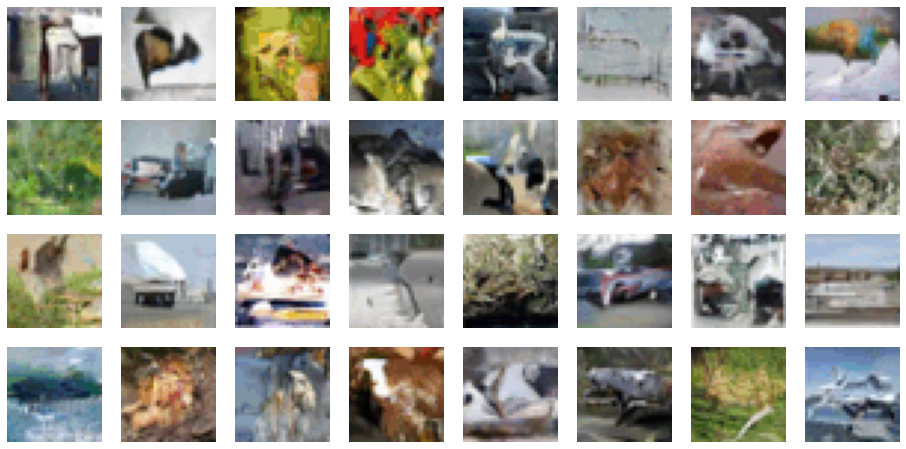

In [31]:
# for visualization we have to invert the permutation used to produce the pixels
iperm = tf.argsort(
    perm, axis=-1, direction='ASCENDING', stable=False,
)

ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = tf.gather(pixels[i], indices=perm)# note: undo the encoding permutation
    plt.subplot(nrow, ncol, i+1)
    decode_img = (
        tf.cast(
        tf.reshape(
            tf.gather(C, indices=pxi), shape=(32, 32, 3)
        ), dtype=tf.float32)
    )
    plt.imshow(decode_img)
    plt.axis('off')

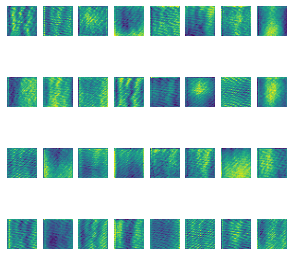

In [33]:
# visualize some of the learned positional embeddings, maybe they contain structure
plt.figure(figsize=(5, 5))
nsee = 32
ncol = 8
nrow = nsee // ncol
for i in range(nsee):
    ci = model.pos_emb[0, :, i]
    zci = tf.concat([tf.constant([0.0]), ci], axis=0) # pre-cat a zero
    rzci = tf.gather(zci, indices=iperm) # undo the permutation to recover the pixel space of the image
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(tf.reshape(rzci, shape=(32,32)).numpy())
    plt.axis('off')